#Installing Libraries

In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!pip install pyreadr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# instructions from here: https://colab.research.google.com/drive/1c_RGCgQeLHVXlF44LyOFjfUW32CmG6BP#scrollTo=LAZ11nESX6qt
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [3]:
!conda install jax==0.2.17 numpyro==0.7.1 -c conda-forge

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / done

# All requested packages already installed.



In [4]:
import time
import math
import numpy as np
from shapely import geometry
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pickle
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import pyreadr
import seaborn as sns
import sys
import tensorflow as tf
import PIL
import tensorflow_probability as tfp
import glob

# JAX
import jax.numpy as jnp
from jax import random, lax, jit, ops
from jax.experimental import stax

from functools import partial

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

import pickle

#Data Cleaning and Analysis

In [7]:
def contact_vector(dt):
  dt = dt.drop_duplicates()
  new_dt = np.zeros((1936, 3))
  dt = dt.to_numpy()
  num = 6
  prev = 6
  for i in range(1936):
    if i == 0:
      new_dt[i][0] = 6
      new_dt[i][1] = 6
    else:
      if prev == 49:
        prev = 6
        num = num+1
        new_dt[i][0] = num
        new_dt[i][1] = prev
      else:
        prev = prev+1
        new_dt[i][0] = num
        new_dt[i][1] = prev
    for j in range(len(dt)):
      if new_dt[i][0] == dt[j][0] and new_dt[i][1] == dt[j][1]:
        new_dt[i][2] = dt[j][2]
  return new_dt[:, 2] 

In [16]:
simulation_list = []
for i in range(100):
  dt = pyreadr.read_r('simAgeGender_preCovid19_2000_BICS-wave3_cap-3_dataset-' + str(i+1) + '.rds')[None]
  dt = dt.drop('part_id', axis = 1)
  dt = dt.drop('alter_gender2', axis = 1)
  dt = dt.drop('cntct_rate', axis = 1)
  dt = dt.drop('pop', axis = 1)
  dt = dt.drop('gender_label', axis = 1)
  dt = dt.drop('alter_gender_label', axis = 1)
  dt = dt.drop('cntcts', axis = 1)
  dt = dt.drop('cntcts_t', axis = 1)
  dt = dt.drop('capped_cntcts', axis = 1)
  dt = dt.to_numpy()
  dt_MF = dt #Dataset only with contact intensities between males and females
  dt_MF_list = []
  for contact in dt_MF:
    if contact[1] == 'Female' and contact[3] == 'Male':
      contact = np.delete(contact, 1)
      contact = np.delete(contact, 2)
      dt_MF_list.append(contact)
  dt_MF = np.array(dt_MF_list)
  dt_MF = pd.DataFrame(dt_MF, columns = ['alter_age', 'age', 'cntct_intensity'], dtype = float)
  dt_MF = dt_MF.drop_duplicates()
  dt_MF = contact_vector(dt_MF)
  simulation_list.append(dt_MF)

In [17]:
def preprocess_cncts(images):
  images = images.reshape((44, 44, 1))
  return images

In [18]:
simulated_heatmaps = [preprocess_cncts(simulation_list[i]) for i in range(len(simulation_list))]
train_data = simulated_heatmaps[0:79]
test_data = simulated_heatmaps[80:99]
train_data = np.array(train_data, dtype = np.float32)
test_data = np.array(test_data, dtype = np.float32)
train_data = list(train_data)
test_data = list(test_data)

In [19]:
train_size = 80
batch_size = 3
test_size = 20
train_dataset = (tf.data.Dataset.from_tensor_slices(train_data).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_data).shuffle(test_size).batch(batch_size))

#Defining the CVAE

In [31]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(44, 44, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=11*11*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(11, 11, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [37]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [38]:
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 1

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [39]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.gca().invert_yaxis()
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [40]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

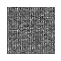

Epoch: 1, Test set ELBO: -1335.177978515625, time elapse for current epoch: 2.1081795692443848


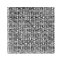

Epoch: 2, Test set ELBO: -1318.5203857421875, time elapse for current epoch: 0.16081714630126953


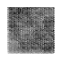

Epoch: 3, Test set ELBO: -1222.355712890625, time elapse for current epoch: 0.16644287109375


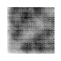

Epoch: 4, Test set ELBO: -1054.4415283203125, time elapse for current epoch: 0.15844368934631348


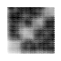

Epoch: 5, Test set ELBO: -939.9473876953125, time elapse for current epoch: 0.15557026863098145


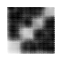

Epoch: 6, Test set ELBO: -840.7241821289062, time elapse for current epoch: 0.15595483779907227


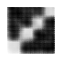

Epoch: 7, Test set ELBO: -760.1790161132812, time elapse for current epoch: 0.154754638671875


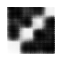

Epoch: 8, Test set ELBO: -709.1949462890625, time elapse for current epoch: 0.15009617805480957


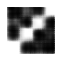

Epoch: 9, Test set ELBO: -683.3807373046875, time elapse for current epoch: 0.1535036563873291


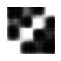

Epoch: 10, Test set ELBO: -664.9658813476562, time elapse for current epoch: 0.15607452392578125


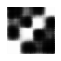

Epoch: 11, Test set ELBO: -648.66943359375, time elapse for current epoch: 0.15238356590270996


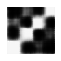

Epoch: 12, Test set ELBO: -630.9595336914062, time elapse for current epoch: 0.15363788604736328


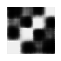

Epoch: 13, Test set ELBO: -611.7980346679688, time elapse for current epoch: 0.15537333488464355


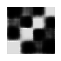

Epoch: 14, Test set ELBO: -589.9692993164062, time elapse for current epoch: 0.15634822845458984


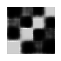

Epoch: 15, Test set ELBO: -563.4313354492188, time elapse for current epoch: 0.15403032302856445


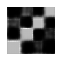

Epoch: 16, Test set ELBO: -533.457275390625, time elapse for current epoch: 0.15335774421691895


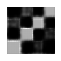

Epoch: 17, Test set ELBO: -498.9385070800781, time elapse for current epoch: 0.15885567665100098


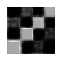

Epoch: 18, Test set ELBO: -461.3700256347656, time elapse for current epoch: 0.160383939743042


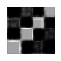

Epoch: 19, Test set ELBO: -420.720947265625, time elapse for current epoch: 0.16067862510681152


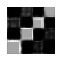

Epoch: 20, Test set ELBO: -378.13983154296875, time elapse for current epoch: 0.1638782024383545


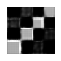

Epoch: 21, Test set ELBO: -332.60302734375, time elapse for current epoch: 0.16327977180480957


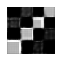

Epoch: 22, Test set ELBO: -281.5607604980469, time elapse for current epoch: 0.15223407745361328


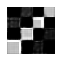

Epoch: 23, Test set ELBO: -224.22592163085938, time elapse for current epoch: 0.15519094467163086


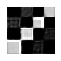

Epoch: 24, Test set ELBO: -154.3310546875, time elapse for current epoch: 0.15171265602111816


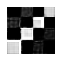

Epoch: 25, Test set ELBO: -47.529205322265625, time elapse for current epoch: 0.15652751922607422


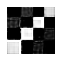

In [41]:
generate_and_save_images(model, 0, test_sample)
epoch = 1
eval = True
while eval==True:
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)
  epoch = epoch+1
  if np.abs(elbo)<70:
    eval = False

## Defining the GP priors

In [ ]:
def dist_euclid(x, z):
    x = jnp.array(x) 
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)


def exp_sq_kernel(x, z, var, length, noise=0, jitter=1.0e-6):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(k.shape[0])
    return k


def GP(gp_kernel, x, jitter=1e-5, var=None, length=None, y=None, noise=False):
    
    if length==None:
        length = numpyro.sample("kernel_length", dist.InverseGamma(4,1))
        
    if var==None:
        var = numpyro.sample("kernel_var", dist.LogNormal(0.,0.1))
        
    k = gp_kernel(x, x, var, length, jitter)
    
    if noise==False:
        numpyro.sample("y",  dist.MultivariateNormal(loc=jnp.zeros(k.shape[0]), covariance_matrix=k), obs=y)
    else:
        sigma = numpyro.sample("noise", dist.HalfNormal(0.1))
        f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(k.shape[0]), covariance_matrix=k))
        numpyro.sample("y", dist.Normal(f, sigma), obs=y)

In [ ]:
def plot_draws(draws, ttl="Priors we want to encode", ylbl='$y=f_{GP}(x)$'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in range(draws.shape[0]):
        ax.plot(x, draws[i,:])
        if i>30: break
    ax.set_xlabel('$x$')
    ax.set_ylabel(ylbl)
    ax.set_title(ttl)

In [ ]:
args = {"n": 20,
        "gp_kernel": exp_sq_kernel,
        "rng_key": random.PRNGKey(2),
        "batch_size": 5
}

# create grid and draw priors
x = [jnp.array((i, j)) for i in jnp.arange(0, 1, 1/args["n"]) for j in jnp.arange(0, 1, 1/args["n"])]
rng_key, rng_key_predict = random.split(random.PRNGKey(4))
gp_predictive = Predictive(GP, num_samples=args["batch_size"])
gp_draws = gp_predictive(rng_key_predict, x=x, gp_kernel = args["gp_kernel"], jitter=1e-5)['y']
#plot_draws(gp_draws, ttl='GP priors we want to encode')

In [ ]:
gp_draws

DeviceArray([[-1.0902861 , -1.12475   , -1.1375703 , ...,  0.6580291 ,
               0.55556035,  0.45825076],
             [-0.01053376,  0.2325363 ,  0.4137621 , ..., -1.6319631 ,
              -1.6896654 , -1.7636865 ],
             [-0.13545363,  0.19565485,  0.39208418, ...,  2.099204  ,
               2.1067502 ,  1.9869084 ],
             [-0.07403217, -0.08464395, -0.09417886, ..., -1.58631   ,
              -1.5724556 , -1.545536  ],
             [ 0.87539136,  0.98002505,  1.0519203 , ..., -0.18663171,
              -0.11604199, -0.11112669]], dtype=float32)

In [ ]:
def vae_encoder(hidden_dim1, hidden_dim2, z_dim):
    return stax.serial(
        stax.Dense(hidden_dim1, W_init=stax.randn()),
        stax.Relu,
        stax.Dense(hidden_dim2, W_init=stax.randn()),
        stax.Relu,
        stax.FanOut(2),
        stax.parallel(
            stax.Dense(z_dim, W_init=stax.randn()), # mean
            stax.serial(stax.Dense(z_dim, W_init=stax.randn()), stax.Exp), # std -- i.e. diagonal covariance
        ),
    )


def vae_decoder(hidden_dim1, hidden_dim2, out_dim):
    return stax.serial(
        stax.Dense(hidden_dim1, W_init=stax.randn()),
        stax.Relu,
        stax.Dense(hidden_dim2, W_init=stax.randn()),
        stax.Relu,
        stax.Dense(out_dim, W_init=stax.randn()) 
    )


def vae_model(batch, hidden_dim1, hidden_dim2, z_dim):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    decode = numpyro.module("decoder", vae_decoder(hidden_dim1, hidden_dim2, out_dim), (batch_dim, z_dim))
    z = numpyro.sample("z", dist.Normal(jnp.zeros((z_dim,)), jnp.ones((z_dim,))))
    gen_loc = decode(z)    
    return numpyro.sample("obs", dist.Normal(gen_loc, .1), obs=batch) 
    

def vae_guide(batch, hidden_dim1, hidden_dim2, z_dim):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    encode = numpyro.module("encoder", vae_encoder(hidden_dim1, hidden_dim2, z_dim), (batch_dim, out_dim))
    z_loc, z_std = encode(batch)
    z = numpyro.sample("z", dist.Normal(z_loc, z_std))
    return z

@jit
def epoch_train(rng_key, svi_state, num_train):

    def body_fn(i, val):
        rng_key_i = random.fold_in(rng_key, i) 
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = random.split(rng_key_i, 4)
        loss_sum, svi_state = val # val -- svi_state
        batch = gp_predictive(rng_key_i, gp_kernel=args["gp_kernel"], x=args["x"], jitter=1e-4)
        svi_state, loss = svi.update(svi_state, batch['y']) 
        loss_sum += loss / args['batch_size']
        return loss_sum, svi_state

    return lax.fori_loop(0, num_train, body_fn, (0.0, svi_state)) #fori_loop(lower, upper, body_fun, init_val)

@jit
def eval_test(rng_key, svi_state, num_test):

    def body_fn(i, loss_sum):
        rng_key_i = random.fold_in(rng_key, i) 
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = random.split(rng_key_i, 4)
        batch = gp_predictive(rng_key_i, gp_kernel=args["gp_kernel"], x=args["x"], jitter=1e-4)
        loss = svi.evaluate(svi_state, batch['y']) / args['batch_size']
        loss_sum += loss
        return loss_sum

    loss = lax.fori_loop(0, num_test, body_fn, 0.0)
    loss = loss / num_test

    return loss

In [ ]:
args = {"num_epochs": 50, 
        "learning_rate": 1.0e-3, 
        "batch_size": 5, 
        "hidden_dim1": 30,
        "hidden_dim2": 30,
        "z_dim": 190,
         "x": x,
        "n": 20,
        "gp_kernel": exp_sq_kernel,
        "rng_key": random.PRNGKey(1),
        "num_warmup": 1000,
        "num_samples": 1000,
        "num_chains": 4,
        "thinning": 1
        }

In [ ]:
adam = optim.Adam(step_size=args["learning_rate"])

svi = SVI(vae_model, vae_guide, adam, Trace_ELBO(), 
          hidden_dim1=args["hidden_dim1"], 
          hidden_dim2=args["hidden_dim2"], 
          z_dim=args["z_dim"])

rng_key, rng_key_samp, rng_key_init = random.split(args["rng_key"], 3)
init_batch = gp_predictive(rng_key_predict, x=args["x"], gp_kernel = args["gp_kernel"])['y']
svi_state = svi.init(rng_key_init, init_batch)

In [ ]:
test_loss_list = []

for i in range(args['num_epochs']):
    
    rng_key, rng_key_train, rng_key_test, rng_key_infer = random.split(rng_key, 4)
    
    t_start = time.time()

    num_train = 1000
    _, svi_state = epoch_train(rng_key_train, svi_state, num_train)

    num_test = 1000
    test_loss = eval_test(rng_key_test, svi_state, num_test)
    test_loss_list += [test_loss]

    print(
        "Epoch {}: loss = {} ({:.2f} s.)".format(
            i, test_loss, time.time() - t_start
        )
    )
    
    if math.isnan(test_loss): break

Epoch 0: loss = 12762.693359375 (45.67 s.)
Epoch 1: loss = 12819.388671875 (21.09 s.)
Epoch 2: loss = 12593.6552734375 (20.85 s.)
Epoch 3: loss = 12639.4755859375 (20.74 s.)
Epoch 4: loss = 12633.716796875 (21.00 s.)
Epoch 5: loss = 12467.88671875 (20.58 s.)
Epoch 6: loss = 10840.58203125 (21.74 s.)
Epoch 7: loss = 10131.5009765625 (21.00 s.)
Epoch 8: loss = 9863.1474609375 (21.25 s.)
Epoch 9: loss = 9929.064453125 (20.86 s.)
Epoch 10: loss = 7379.5615234375 (20.63 s.)
Epoch 11: loss = 7245.45654296875 (20.74 s.)
Epoch 12: loss = 7418.341796875 (20.51 s.)
Epoch 13: loss = 7248.5322265625 (20.69 s.)
Epoch 14: loss = 6246.13134765625 (20.86 s.)
Epoch 15: loss = 5972.962890625 (20.73 s.)
Epoch 16: loss = 5143.400390625 (21.05 s.)
Epoch 17: loss = 4959.43310546875 (21.54 s.)
Epoch 18: loss = 4862.87646484375 (20.93 s.)
Epoch 19: loss = 4892.3447265625 (20.72 s.)
Epoch 20: loss = 4985.14453125 (20.62 s.)
Epoch 21: loss = 4861.45947265625 (20.68 s.)
Epoch 22: loss = 4750.3486328125 (20.83 s.

In [3]:
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic()

In [4]:
xs = np.arange(0, 1, 1/25)

In [17]:
x2ds = [np.array([i, j]) for i in xs for j in xs]

In [18]:
x2ds=np.asarray(x2ds)

In [8]:
index_points = np.expand_dims(np.linspace(-1., 1., 25), -1)

In [12]:
index_points[0].shape

(1,)

In [19]:
tfd = tfp.distributions

In [22]:
gp = gp = tfd.GaussianProcess(kernel, index_points, always_yield_multivariate_normal=True)

In [23]:
samples = gp.sample(10)

<tf.Tensor: shape=(10, 25), dtype=float64, numpy=
array([[-2.25330628, -2.08775038, -1.90979486, -1.72650133, -1.54042551,
        -1.35354282, -1.1739146 , -0.99989635, -0.84106822, -0.6929178 ,
        -0.56349943, -0.4496519 , -0.3544517 , -0.27801135, -0.22431971,
        -0.18594509, -0.16702397, -0.16327789, -0.17333624, -0.1938469 ,
        -0.22472911, -0.25973497, -0.29887268, -0.33742862, -0.37478424],
       [ 0.9037532 ,  0.91762601,  0.92721951,  0.93554111,  0.93768674,
         0.94160958,  0.94046492,  0.94297176,  0.94566104,  0.95319323,
         0.96644876,  0.98861777,  1.02108212,  1.06541929,  1.12185298,
         1.18791111,  1.26621798,  1.34831415,  1.43909235,  1.52770476,
         1.61454698,  1.69175154,  1.75758559,  1.80597392,  1.83565924],
       [ 1.29199357,  1.15897361,  1.02036607,  0.87831485,  0.74127329,
         0.60605635,  0.48113892,  0.36879773,  0.27480826,  0.19690577,
         0.13858096,  0.09991127,  0.07821572,  0.07410582,  0.08043689,